# Enrichment Analyses of GATA1-knockout Mice
_Anders Dohlman_ and _Avi Ma'ayan_

_Icahn School of Medicine at Mount Sinai_; _Department of Pharmacology and Systems Therapeutics_; _BD2K-LINCS Data Coordination and Integration Center_; _One Gustave L. Levy Place, Box 1603, New York, NY 10029 USA_

## Introduction
In animal models and patients with autoimmune disease, fibroblasts are activated by ERK and p38, which are members of the non-canonical TGF-beta pathway triggered by MAPK signaling. In published work by [_Ciaffoni et al._](http://www.ncbi.nlm.nih.gov/pubmed/25703685), a mechanism for primary myelofibrosis (PMF) in bone marrow was predicted, in which dead megakaryocytes triggered the non-canonical TGF-beta pathway to induce an autoimmune response.

Here we profile the effects of GATA1 knockout in PMF mice. The GATA1 transcription factor is a regulator of hematopoeisis and erythroid development, and its activation targets include in HBB, HBG1/2, ALS2, and HMBS. In previous studies by [_Zingariello et al_](http://www.ncbi.nlm.nih.gov/pubmed/23462118), GATA1-low mice have demostrated abnormal TGF-beta signaling in marrow of GATA1-low myelofibrotic mice, characterized by increased apoptosis and G1 arrest. 

## Methods
Bone marrow samples were taken from three controls and three GATA1-knockouts to profile changes in gene expression. The six myelofibrotic bone marrow samples were taken from mice were run on a Illumina microarray chip and processed by the Genomics Core Facility at MSSM. The data were quantile-normalized and reported in "FinalReport.txt". The "Sample Gene Profile" section of the report was selected and parsed, then saved as "gata1_gene_profile.txt".

### Data preparation
* First, 30,854 gene profiles were extracted from "FinalReport.txt".
* We selected the "AVG_Signal" column for each of 6 samples:
    * **Controls**: cd1, cd2, cd3
    * **Knockouts**: gat1, gat2, gat3
3. The 30854 x 6 matrix was saved as "gata1_gene_profile.txt".


In [28]:
# Load dependencies
%matplotlib inline
import matplotlib
import json
import time
import requests
import os.path
import pandas as pd
import numpy as np
from sklearn import decomposition
from scipy.stats import zscore
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import HTML as ipyHTML
import HTML as table2html

# Load data
df = pd.read_table('gata1_gene_profile.txt',sep='\t',index_col=0)
genelist = df.index.values
samples = df.columns.values

### Quality Control
After observing that negative signals corresponded to low confidence values, we mapped all negative values to zero. A negative value means less fluorescent than the control, meaning that no signal is present. Next, we checked the microarray expression distributions using a log-normalized histogram for each sample.

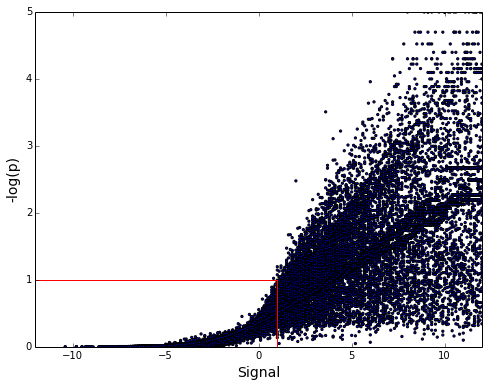

In [29]:
pvals = df[['cd1.Detection Pval','cd2.Detection Pval','cd3.Detection Pval',
            'gat1.Detection Pval','gat2.Detection Pval','gat3.Detection Pval']]
signal = df[['cd1.AVG_Signal','cd2.AVG_Signal','cd3.AVG_Signal',
             'gat1.AVG_Signal','gat2.AVG_Signal','gat3.AVG_Signal']]

fig = plt.figure(figsize=(8, 6), dpi=80)
x = list(pd.melt(signal)['value'])
y = list(pd.melt(-np.log10(pvals))['value'])
plt.axis([-12, 12, 0, 5])
plt.scatter(x,y,s=5)
plt.xlabel('Signal',fontsize=14)
plt.ylabel('-log(p)',fontsize=14)
plt.plot([-12,1],[1,1],'r-'); plt.plot([1,1],[0,1],'r-')
plt.show()

In [38]:
# Replace all negative values with zero
pd.options.mode.chained_assignment = None  # default='warn'
signal[signal < 0] = 0

# Keep rows with 3 or more values greater than 0
# keep = [ i for i in range(len(signal)) if sum(1 for j in range(6) if signal.iloc[i,j]>0)>=3 ]

df = signal
# df = signal.iloc[keep,:]
samples = [x.split('.')[0] for x in df.columns.values]
df.columns = samples

Now we check the log-distribution of gene expression values in each sample.

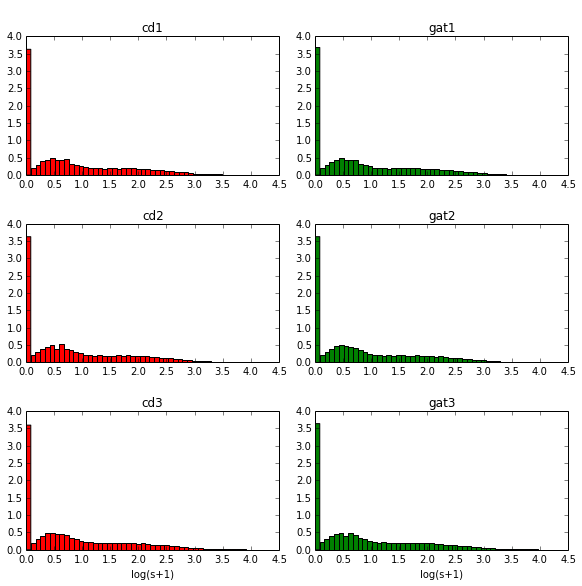

In [42]:
# Log transform
logDf = np.log10(df+1)

fig = plt.figure(figsize=(8, 8), dpi=80)

# Plot histograms of data
for i in range(1,7):
    fig.add_subplot(3,2,i)
    if i%2 == 0: s,col = 'gat' + str(i/2), 'green'
    else: s,col = 'cd' + str((i+1)/2), 'red'
    n, bins, patches = plt.hist(logDf[s], 50, normed=1, facecolor=col, alpha=1)
    plt.title('\n'+s)
    if int(s[-1]) == 3: plt.xlabel('log(s+1)')
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=0.8)

The normalization and filtering yeilds us comparable distributions.

### PCA Visualization of Samples
To compare the samples, we performed a principal component analysis. This method visualizes the major axes of variance the genespace. A visual explanation of PCA can be found [_here_](http://setosa.io/ev/principal-component-analysis/).

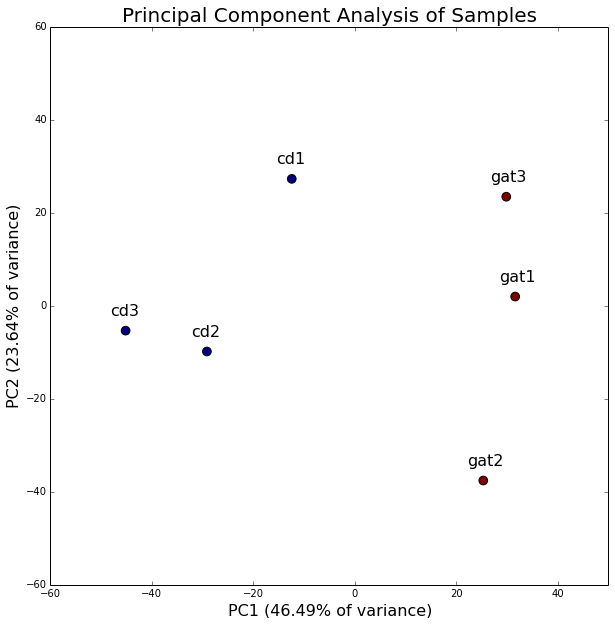

In [32]:
# Choose 2000 genes with greatest variance and zscore them
mat = df.transpose().as_matrix()
featvars = list(np.var(mat,axis=0))
select = np.argsort(featvars)[-2000:] 
mat = zscore(mat[:,select])

# Compute PCA Coordinates and Variance
pca = decomposition.PCA(n_components=None)
pca.fit(mat)
variance_explained = pca.explained_variance_ratio_[0:2] * 100
pca_coords = pca.transform(mat)[:, 0:2]
pca1, pca2 = zip(*pca_coords)

# Plot Results
fig = plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(pca1,pca2,s=75,c=[1,1,1,2,2,2])
labels = ['PC%s (%.2f' % (i,pct) + '%' + ' of variance)'
          for i,pct in enumerate(variance_explained, start=1)]
for label, x, y in zip(samples,pca1,pca2):
    plt.annotate(label,xy=(x,y),xytext = (-15, 15), textcoords = 'offset points', fontsize=16)
plt.xlabel(labels[0],fontsize=16)
plt.ylabel(labels[1],fontsize=16)
plt.axis([-60, 50, -60, 60])
plt.title("Principal Component Analysis of Samples",fontsize=20)
plt.show()

The clear separation between samples suggests they are a strong candidate for a robust differential expression signature.

### Processing the GATA1-/-  data into CD signatures
The Characteristic Direction (CD) method was used to compute differentially expressed genes. It computes the unit vector perpendicular the linear discriminant hyperplane separating control and sample conditions. An in-depth description of this method was published to [_BMC Bioinformatics_](http://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-79) in 2014. The python implementation used here can be found in the [_Ma'ayan Lab Github Repository_](https://github.com/MaayanLab/chdir/blob/master/chdir.py).

In [33]:
from chdir import chdir

ctrData = df[['cd1','cd2','cd3']].values
expData = df[['gat1','gat2','gat3']].values

# Get the charactersitic direction signature
[cdGenes,cdVector] = chdir(ctrData,expData,genelist)

Calculating the characteristic direction.
Done chdir


### Enrichment Analysis

Enrichment analysis was accomplished via the Enrichr API. The top 500 most up- and down-regulated genes were submitted and enrichment results were retrieved for the following enrichment libraries:
* MGI Mammalian Phenotype
* Wikipathways
* ChEA
* PPI Hub Proteins

In [34]:
# Libraries to use:
libraries = ['MGI_Mammalian_Phenotype_Level_4','WikiPathways_2015','ChEA_2015','PPI_Hub_Proteins']

# Use this function to call the Enrichr API:
ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
def fetch_enrichr_results(genes, description=''):
    """Returns a dict which maps Enrichr libraries to enrichment results."""
    session = requests.session()
    payload = {'list': (None, genes), 'description': (None, description)}
    session.post(ENRICHR_URL, files=payload)
    results = {}
    for library in libraries:
        get_url = ENRICHR_URL + '?backgroundType=%s' % library
        response = session.get(get_url)
        print [str(x) for x in json.loads(response.text).keys()]
        if response.ok:
            results[library] = json.loads(response.text)[library]
        else: print "Error"
    return results

In [35]:
# Get 500 most up- and down-regulated genes
n = 500
geneOrder = [cdGenes[x] for x in np.argsort(cdVector)]

upGenes = geneOrder[-n:]
dnGenes = geneOrder[:n]

up = open('gata1_upGenes.txt','w'); dn = open('gata1_dnGenes.txt','w')
for gene in upGenes: up.write(gene+'\n')
for gene in dnGenes: dn.write(gene+'\n')
up.close(); dn.close()

# Choose enrichr libraries to use
upOutput = fetch_enrichr_results('\n'.join(upGenes),'GATA1-/-')
dnOutput = fetch_enrichr_results('\n'.join(dnGenes),'GATA1-/-')

['MGI_Mammalian_Phenotype_Level_4']
['WikiPathways_2015']
['ChEA_2015']
['PPI_Hub_Proteins']
['MGI_Mammalian_Phenotype_Level_4']
['WikiPathways_2015']
['ChEA_2015']
['PPI_Hub_Proteins']


In [36]:
upResults = {}
dnResults = {}

nrows = 10 # Number of terms to display per library

# Do a little formatting
for library in libraries:
    upResults[library] = []
    dnResults[library] = []
    for i in range(len(upOutput[library])):
        line = [ '{:.4e}'.format(x) if type(x)==float else x for x in upOutput[library][i][:-2]]
        if library == 'KEGG_2016': line[1] = line[1][:-22]
        elif library == 'MGI_Mammalian_Phenotype_Level_4': line[1] = line[1][10:].replace('_',' ').title()
        elif library == 'WikiPathways_2015': line[1] = line[1].replace('(',' (').title()
        elif library == 'ChEA_2015': line[1] = '_'.join([line[1].split('_')[0]]+line[1].split('_')[2:])
        genestring = ', '.join(upOutput[library][i][-2])
        upResults[library].append(line + [genestring])
    for i in range(len(dnOutput[library])):
        line = [ '{:.4e}'.format(x) if type(x)==float else x for x in dnOutput[library][i][:-2]]
        if library == 'KEGG_2016': line[1] = line[1][:-22]
        elif library == 'MGI_Mammalian_Phenotype_Level_4': line[1] = line[1][10:].replace('_',' ').title()
        elif library == 'WikiPathways_2015': line[1] = line[1].replace('(',' (').title()
        elif library == 'ChEA_2015': line[1] = '_'.join([line[1].split('_')[0]]+line[1].split('_')[2:])
        genestring = ', '.join(dnOutput[library][i][-2])
        dnResults[library].append(line + [genestring])

## Enrichment Results
Below are tables for MGI, KEGG, ChEA, and PPI enrichment results. Click the links below to view the full results on Enrichr :
* [Upregulated genes](http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=6j5t)
* [Downregulated genes](http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=6j5s)

In [37]:
fields = ["Rank","Term","p-value","z-score","Combined Score","Related Genes"]

# Now plot the tables
for library in libraries:
    htmlcode = table2html.table(upResults[library][:nrows],header_row=fields)
    print library.replace('_',' ')+": Up"
    display(ipyHTML(htmlcode))
    htmlcode = table2html.table(dnResults[library][:nrows],header_row=fields)
    print library.replace('_',' ')+": Down"
    display(ipyHTML(htmlcode))

MGI Mammalian Phenotype Level 4: Up


MGI Mammalian Phenotype Level 4: Down


WikiPathways 2015: Up


WikiPathways 2015: Down


ChEA 2015: Up


ChEA 2015: Down


PPI Hub Proteins: Up


PPI Hub Proteins: Down


### Phenotypes
Every one of the top-ten enrichment terms for up-regulated genes was related to abnormal immune system phenotypes. This included enrichment for both innate and adaptive immunity abnormalities, as well as anormal blood cells, immune cells, and blood marrow. Highly enriched terms also include "abnormal antigen presenting", "abnormal immune serum", "abnormal response to infection”, and “abnormal humoral immune response”.

Among down-regulated genes, the phenotype for "abnormal erythrocyte physiology“ was the most highly ranked. Abnormal blood cells and bone marrow were also highly ranked. Together, these terms imply that the GATA1 plays an important role in the normal function of the immune system.


### Pathways
Among Wikipathways terms, we found enrichment for hematopoiesis-related pathways in both up- and down-regulated genes. Up-regulated genes showed enrichment for Toll-like receptor signaling as well as B Cell receptor signaling.  Toll-like receptors mediate RAC and are responsile for activating the innate immune system. The term “IL1 and megakaryocytes in obesity” was also significantly enriched among up-regulated genes. IL1 activates the p38/MAPK pathway in megakaryocytes and is also implicated in Toll-like receptor signaling.

The most enriched pathway among down-regulated genes was G1 to S Cell Cycle control. we found enrichment for the Heme Biosynthesis, with genes such as ALAD, ALAS2, FECH, UROD, UROS, and PPOX implicated. Notably, TGF-beta signaling pathway was low on the list of enrichment terms for both up- and down-regulated genes. However, this is likely be due to the fact that GATA1 participates in a non-canonical TGF-beta signaling pathway and may not be represented by the Wikipathways library. 


### Transcription Factors
Firstly, we note that GATA1 and GATA2 appeared several times among the top ChEA terms for down-regulated genes, giving confidence to the strength of the enrichment results.

The two highest-ranked ChEA terms among up-regulated genes was MYB and MECOM, both of which are transcription factors that play important roles in the regulation of hematopoiesis. Additionally, there is evidence that MECOM, also known as EVI1, plays a role in apoptosis via the TGF-beta signaling pathway. Other transcription factor regulators of the immune system were also enriched, including SPI1, STAT1, and STAT4. The transcription factor EKLF, also known as KLF1, was highly enriched in both up- and down-regulated gene sets, and is necessary for erythroid maturation.

Among down-regulated genes, the most highest-enriched transcription factor was TAL1. Also enriched among up-regulated genes, this transcription factor is a positive regulator of erythroid differentiation and has been implicated in hematopoiesis. Well-known transcription factor MYC also appeared several times among down-regulated enrichment terms. It plays a role in PI3K-Akt and MAPK signaling pathways.


### Hub Proteins
For both up- and down-regulated genes, the protein SLC2A4 was among the most highly enriched. This protein transports glucose across the cell membrane in response to insulin. Also highly enriched among up-regulated genes was IL7R, a receptor protein that is expressed in T lymphocytes.  Also of note is protein kinase IKBKE, which regulates the viral inflammatory response and is known to phosphorylate STAT1 and AKT1.

Among down-regulated genes, the most highly enriched hub protein was ARRB2. This protein is involved in GPCR desensitization and acts as signaling scaffold for MAPK pathways, such as ERK1/2. It has also been implicated in Toll-like receptor and IL-1 receptor signaling through interaction with TRAF6, a transcription factor that is also enriched among down-regulated genes.


## Conclusions and Discussion
Together, enrichment analysis supports the hypothesis that GATA1 is involved in a non-canonical MAPK-dependent activation of TFG-beta signaling in primary myelofibrotic mice. The strong signal for the abnormal immune system phenotype distinctly indicates an autoimmune response by up-regulated genes. Furthermore, enrichment for the Toll-like receptor pathway and the IL1 pathway in megakaryocytes indicates that this response may be due to the MAPK-activated non-canonical TGF-beta pathway. Particularly, this gives strength to hypothesis that this process is driven by megakaryocyte death. Enrichment results for proteins and transcription factors such as ARRB2, MYB, MECOM (EVI1), and STAT1 also implicate MAPK signaling, and provide greater evidence that EVI1 may be downstream of the p38/MAPK signaling pathway of megakaryopoiesis in primary myelofibrosis.
